# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

In [1]:
import pandas as pd

from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.feature_selection import f_classif
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 50) 
pd.set_option('display.max_columns', 50)

In [2]:
try:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
except:
    data = pd.read_csv('real_estate_data.csv', sep='\t')
df = data.copy() # оставим себе копию для проверки
data.sample(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
7853,7,950000.0,52.0,2017-09-18T00:00:00,2,NaN,2.0,30.0,1,NaN,False,False,8.0,NaN,деревня Пельгора,NaN,NaN,NaN,NaN,NaN,NaN,231.0
11338,17,3500000.0,72.0,2019-03-24T00:00:00,3,2.5,5.0,43.2,4,NaN,False,False,8.6,NaN,Приозерск,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Описание данных
airports_nearest — расстояние до ближайшего аэропорта в метрах (м)  
balcony — число балконов  
ceiling_height — высота потолков (м)  
cityCenters_nearest — расстояние до центра города (м)  
days_exposition — сколько дней было размещено объявление (от публикации до снятия)  
first_day_exposition — дата публикации  
floor — этаж  
floors_total — всего этажей в доме  
is_apartment — апартаменты (булев тип)  
kitchen_area — площадь кухни в квадратных метрах (м²)  
last_price — цена на момент снятия с публикации (target)  
living_area — жилая площадь в квадратных метрах (м²)  
locality_name — название населённого пункта  
open_plan — свободная планировка (булев тип)  
parks_around3000 — число парков в радиусе 3 км  
parks_nearest — расстояние до ближайшего парка (м)  
ponds_around3000 — число водоёмов в радиусе 3 км  
ponds_nearest — расстояние до ближайшего водоёма (м)  
rooms — число комнат  
studio — квартира-студия (булев тип)  
total_area — общая площадь квартиры в квадратных метрах (м²)  
total_images — число фотографий квартиры в объявлении

In [3]:
# functions place

# Напишем простенькую функцию для заполнения пропусков через fit_predict
def fill_na_pred(target, *features):
    """
    На вход первой подаем целевую переменную для заполнения пропусков
    следующими идут признаки, через которые делаем предикт
    """

    features = list(features)
    X_train = data[~data[target].isna()][features]
    X_pred =  data[data[target].isna()][features]
    y_train = data[~data[target].isna()][target]
    
    rfr = RandomForestRegressor()
    rfr.fit(X_train, y_train)
    y_pred = rfr.predict(X_pred)

    data.loc[data[target].isna(), target] = y_pred

# Для заполнения пропусков где можно присвоить значение по городу
def fill_na_town(feature): 
    """
    На вход будем подавать признак. Искать по каждому городу медиану этого признака
    и заполнять пропуски если есть
    """
    towns = data['locality_name'].unique()
    town_median_df = data.groupby('locality_name')[feature].median() # Сериз с медианами признака (там где есть)
    for town in towns:
        try:
            data.loc[(data['locality_name']==town)&(data[feature].isna()), feature] = town_median_df[town]
        except:
            continue

# быстрый осмотр признака после очистки
def fast_look(feature, bins=20):
    data[feature].hist(bins = bins)
    print(data[feature].describe())
    
    
    
# Добавим сюда маску для датафрэйма, которую будем считать однородной
# Питер, жилье возле КАДа, самое ходовое 40-60 квадратов

mask = ((data['locality_name']=='Санкт-Петербург')&
        (data['total_area'].between(40,60))&
        data['cityCenters_nearest'].between(13000,16000))



In [4]:
# посмотрим на датасет
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

На первый взгляд, как видим, в основном у нас числовые признаки. К object относятся:  
- first_day_exposition - на самом деле дата,
- is_apartment (на самом деле это bool, только около 90% пропусков)
- locality_name (название населенного пункта)  
Видим, так же, что много пропусков в данных. В некоторых признаках почти до 90% пропущено       


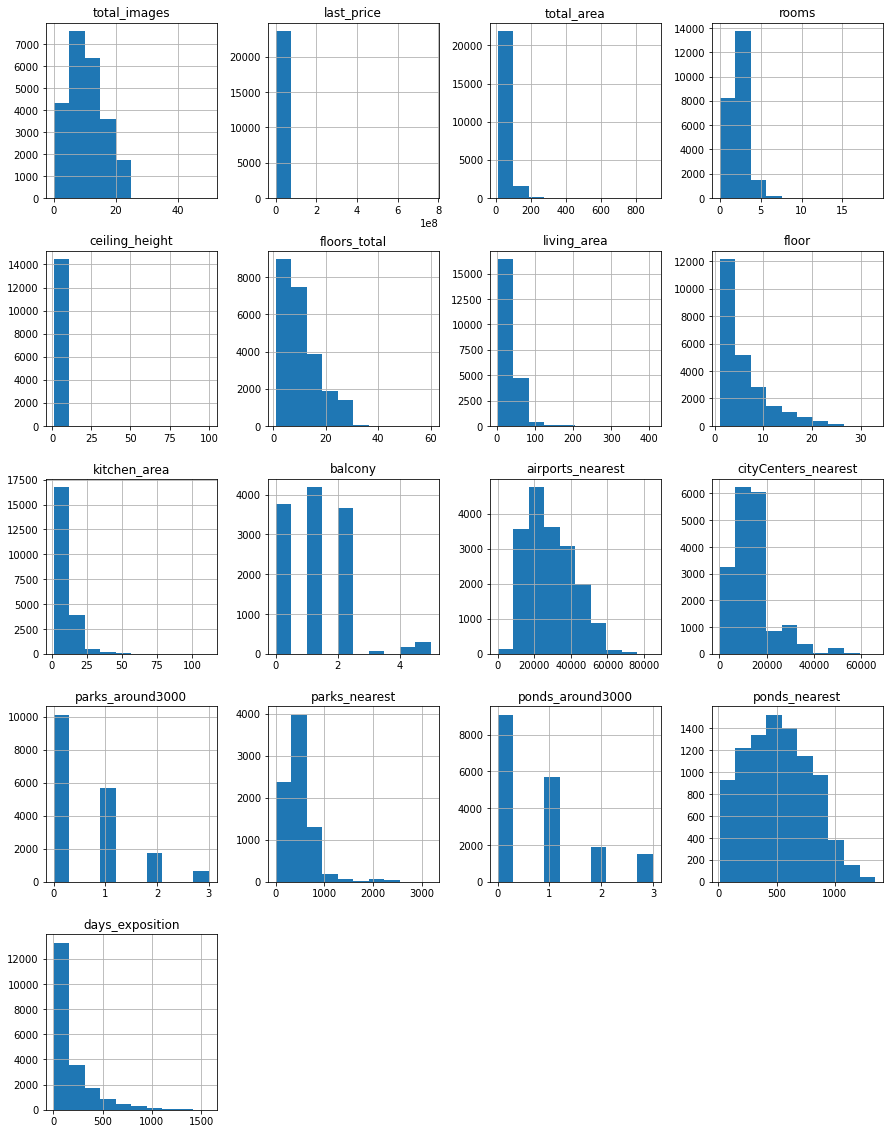

In [5]:
# посмотрим на гистограммы, но данных таким образом немного. Смотреть надо каждый признак индивидуально
# и следующий примененный метод подчодит для этого намного лучше
data.hist(figsize=(15,20));

In [6]:
# Мне больше нравится метод ProfileReport из pandas_profiling. Дает более полное первичное описание признаков
ProfileReport(data)

# скинем отчет в отдельный html файл для удобства

#profile = ProfileReport(data)
#profile.to_file(r"first_look_data.html")

# Воспользуемся готовым отчетом полученным на локальном компьтере
path = 'https://drive.google.com/file/d/1w1mLiEMY_TxQpAPSB-if02XivYei2s0z/view?usp=sharing'

print('По этой ссылке можно скачать отчет профайлинга')
print(path)

#import IPython
#iframe = '<iframe width="900" height="800" frameborder="0" scrolling="no" src="https://drive.google.com/uc?id=1w1mLiEMY_TxQpAPSB-if02XivYei2s0z"></iframe>'
#IPython.display.HTML(iframe)



По этой ссылке можно скачать отчет профайлинга
https://drive.google.com/uc?id=1w1mLiEMY_TxQpAPSB-if02XivYei2s0z


Итак, что можно сказать на первый взгляд. Данные довольно сырые. Много пропусков почти 20% данных. Дубликатов нет.
Имеем 15 числовых, 4 категориальных и 3 бинарных признака.  
В некоторых признаках есть выбросы. Так же прослеживается значительная корреляция между некоторыми признаками. Возможно некоторые из них будут избыточными.  
Посмотрим признаки более тщательно в следующей части.

### Предобработка данных

#### Пропуски

In [7]:
# Выведем признаки с пропусками
cols_with_miss = data.isna().sum()[data.isna().sum()!=0].index
cols_with_miss

Index(['ceiling_height', 'floors_total', 'living_area', 'is_apartment',
       'kitchen_area', 'balcony', 'locality_name', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype='object')

In [8]:
# подсветим красиво
pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
total_images,0.000000
last_price,0.000000
total_area,0.000000
first_day_exposition,0.000000
rooms,0.000000
ceiling_height,39.000000
floors_total,0.000000
living_area,8.000000
floor,0.000000
is_apartment,88.000000


In [9]:
# Начнем не по порядку. С kitchen_area. У признака прямая корреляция с общей  площадью.
# добавим столбец с долей кухни от общей площади
data['kitchen_perc'] = data['kitchen_area']/data['total_area']
data['kitchen_perc'].describe()

count    21421.000000
mean         0.187355
std          0.072968
min          0.025381
25%          0.133333
50%          0.172414
75%          0.232416
max          0.787879
Name: kitchen_perc, dtype: float64

In [10]:
# межквартильный pазмах приличный от 0.13 до 0.23
# попробуем разбить площадь на категории (до 40, от 40 до 70, больше 70)
def make_area_cat(square):
    if square <= 40:
        return "маленькая квартира"
    elif 40 < square <= 60:
        return "средняя квартира"
    else:
        return "большая квартира"
    
data['area_cat'] = data['total_area'].apply(make_area_cat)

# и посмотрим, есть ли разница по медиане в доле площади кухни в зависимости от категории квартиры
data.groupby('area_cat')['kitchen_perc'].median()

area_cat
большая квартира      0.142664
маленькая квартира    0.236842
средняя квартира      0.160000
Name: kitchen_perc, dtype: float64

как видим - есть зависимость: чем меньше квартира, тем большая доля у кухни.  
Вижу два способа заменить пропуски:  
- можно поколдовать с категориями и заполнить пропуски медианой в зависимости от категории
- можно сделать предикт используя за основную фичу total_area (и количество комнат)
медиану делать скучно. Посмотрим, что получится с предиктом

In [11]:
# Заполним пропуски предиктом
fill_na_pred('kitchen_area', 'total_area')


# Обновим столбец с долей кухни исходя из заполненных пропусков

data['kitchen_perc'] = data['kitchen_area']/data['total_area']
data['kitchen_perc'].describe()

count    23699.000000
mean         0.188018
std          0.071021
min          0.025381
25%          0.136364
50%          0.174194
75%          0.230724
max          0.787879
Name: kitchen_perc, dtype: float64

Как видим распределение долей кухни сохранилось. 
В идеале можно было бы разбить трэйн на две части и оценить точность модели, но будем исходить из того, что раз распределение долей кухни осталось таким же, значит точность достаточная.

In [12]:
# Теперь можно рассмотреть признак ceiling_height - высота потолков. Пропущено почти 40% значений. Есть выбросы.
# высота потолка варьируется от 1 до 100. Причем 5 персентиль это 2.5, а 95й - 3.3, что похоже на правду, если высота в метрах.
# в профайле мы получили корреляцию с площадью кухни. (которая в свою очередь имеет высокую корреляцию с общей площадью).

data.groupby('area_cat')['ceiling_height'].median()

area_cat
большая квартира      2.75
маленькая квартира    2.60
средняя квартира      2.60
Name: ceiling_height, dtype: float64

Вообще с таким количеством пропусков (почти 40%), я считаю оставлять его в качестве признака для целевой переменной будет нецелесообразно.
Плюс, в нем еще много выбросов.

Чисто для тренировки:  
- обработаем "высокие" потолки, предположив, что там просто пропустили запятую
- заменим пропуски медианой

<AxesSubplot:>

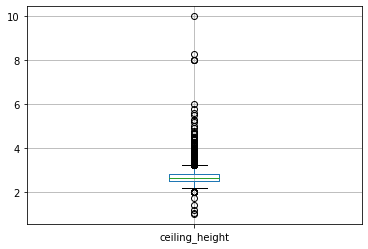

In [13]:
data['ceiling_height'] = data['ceiling_height'].where(data['ceiling_height']<10, data['ceiling_height']/10)
data.boxplot('ceiling_height')

In [14]:
data['ceiling_height'].describe()

count    14504.000000
mean         2.728100
std          0.299855
min          1.000000
25%          2.510000
50%          2.650000
75%          2.800000
max         10.000000
Name: ceiling_height, dtype: float64

Существенно это ситуацию не улучшило. Выбросов много. Пропусков было много. Тут надо поднимать вопрос о качестве заполнения данного столбца

Переосмыслил. Есть мысль сделать из этого не очень удачного признака категориальный, типа:
низкие потолки, высокие потолки, стандартные потолки, нет данных о потолках

In [16]:
def make_height_type(height):
    # за пределы взяты 1 и 3 квантили
    if height < 2.5:
        return "низкие потолки"
    elif 2.5 <= height < 2.8:
        return "средние потолки"
    elif height >= 2.8:
        return "высокие потолки"
    else:
        return "нет данных о высоте потолка"
    
data['height_cat'] = data['ceiling_height'].apply(make_height_type)
data['height_cat'].value_counts()

средние потолки                10380
нет данных о высоте потолка     9195
высокие потолки                 4046
низкие потолки                    78
Name: height_cat, dtype: int64

Признак floors_total. (всего этажей). Здесь пропусков немного, всего 0.4%. Хотелось бы их заполнить, но....  
Понятно, что есть корреляция с этажом квартиры (так как тотал этажей должно быть как минимум не меньше чем этаж квартиры)  
Конечно, если продавец не Карлсон.
Поэтому считаю целесообразным удалить строки с пропусками.

In [18]:
data = data[~data['floors_total'].isna()]

In [19]:
# living_area. Пропусков прилично, 8%. Есть корреляция с общей площадью и количеством комнат.
# считаю целесообразным пропуски заполнить по такому же приципу как и площадь кухни.

fill_na_pred('living_area', 'total_area', 'rooms')

In [20]:
# видим, что есть выбросы. Обработаем их позже.
data['living_area'].describe()

count    23613.000000
mean        34.577014
std         22.396615
min          2.000000
25%         18.600000
50%         30.000000
75%         42.300000
max        409.700000
Name: living_area, dtype: float64

In [21]:
# is_apartment пропущено 88%. Удалим признак
data.drop(columns=['is_apartment'], inplace=True)

In [22]:
# Балконы. Пропущено почти половина (48%). При этом указано отсутствие балкона в 16% случаев.
# В идеале - понять бы откуда пропуски, поговорить с дата-инженерами. Но сейчас предположим, что если количество балконов не указали, то их ноль
data['balcony'].fillna(0, inplace=True)

очень подозрительно выглядят признаки - 'airports_nearest'	'cityCenters_nearest'	'parks_around3000'	'ponds_around3000'  
практически одинаковое количество пропусков.  
Заполним пропуски по тем данным, где можно по городу взять медиану  
Но перед этим посмотрим список городов. Есть пропуски в названии городов? немного - 48шт. Назовем такие "без_названия"

In [23]:
data['locality_name'] = data['locality_name'].where(~data['locality_name'].isna(), "без_названия")

In [24]:
# Создадим список городов
towns = data['locality_name'].unique()
towns

array(['Санкт-Петербург', 'посёлок Шушары', 'городской посёлок Янино-1',
       'посёлок Парголово', 'посёлок Мурино', 'Ломоносов', 'Сертолово',
       'Петергоф', 'Пушкин', 'деревня Кудрово', 'Коммунар', 'Колпино',
       'поселок городского типа Красный Бор', 'Гатчина', 'поселок Мурино',
       'деревня Фёдоровское', 'Выборг', 'Кронштадт', 'Кировск',
       'деревня Новое Девяткино', 'посёлок Металлострой',
       'посёлок городского типа Лебяжье',
       'посёлок городского типа Сиверский', 'поселок Молодцово',
       'поселок городского типа Кузьмоловский',
       'садовое товарищество Новая Ропша', 'Павловск',
       'деревня Пикколово', 'Всеволожск', 'Волхов', 'Кингисепп',
       'Приозерск', 'Сестрорецк', 'деревня Куттузи', 'посёлок Аннино',
       'поселок городского типа Ефимовский', 'посёлок Плодовое',
       'деревня Заклинье', 'поселок Торковичи', 'поселок Первомайское',
       'Красное Село', 'посёлок Понтонный', 'Сясьстрой', 'деревня Старая',
       'деревня Лесколово', '

Видим, что где-то посёлок, где-то поселок и т.д. избавимся от всех этих ПГТ, деревень и пр. Оставим только Имя собственное

In [25]:
def clean_towns(town):
    parasits = ['деревня', 'посёлок', 'поселок', 'городского', 'типа', 'село', 'садовое', 'товарищество', 'коттеджный', 
                'городской', 'посёлок']
    town_list = town.split(' ')
    n = 0 # Костыль, почему то не чистит с первого раза. Остаются слова-паразиты.
    while n < 5:
        for word in town_list:
            if word in parasits:
                town_list.remove(word)
            else:
                n += 1
                continue
    return ' '.join(town_list)

data['locality_name'] = data['locality_name'].apply(clean_towns)

In [26]:
# видим, что из 365 стало 309, уже лучше
data['locality_name'].nunique()

309

В идеале надо понять откуда поступает информация, возможно сделать ввод с фильтром, чтобы не было 10 значений на один городок. 

In [27]:
# теперь посмотрим на "странные признаки"
strange_features = ['airports_nearest', 'cityCenters_nearest', 'parks_around3000', 'parks_nearest', 'ponds_around3000', 'ponds_nearest']

# посмторим разброс
data[strange_features].describe()

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
count,18081.000000,18104.000000,18105.000000,8045.000000,18105.000000,9061.000000
mean,28788.008185,14185.084015,0.611433,490.554630,0.770119,518.209469
std,12626.209956,8614.132292,0.802168,341.336698,0.939075,277.887489
min,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000
25%,18575.000000,9233.750000,0.000000,288.000000,0.000000,294.000000
50%,26726.000000,13093.000000,0.000000,455.000000,1.000000,503.000000
75%,37242.000000,16287.000000,1.000000,612.000000,1.000000,730.000000
max,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000


In [28]:
for feature in strange_features:
    fill_na_town(feature)

data[strange_features].describe()

,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest
count,18181.000000,18181.000000,18181.000000,17627.000000,18181.00000,18096.000000
mean,28776.835460,14185.339778,0.608987,475.888665,0.77086,510.419126
std,12597.911866,8609.856072,0.801514,234.716033,0.93735,199.844621
min,0.000000,181.000000,0.000000,1.000000,0.00000,13.000000
25%,18616.000000,9238.000000,0.000000,434.000000,0.00000,464.000000
50%,26763.000000,13065.000000,0.000000,460.000000,1.00000,504.000000
75%,37153.000000,16275.000000,1.000000,460.000000,1.00000,562.000000
max,84869.000000,65968.000000,3.000000,3190.000000,3.00000,1344.000000


Помогло несильно. Заполнилось всего около 80 - 100 пропусков.
Что можно было бы сделать в идеале:  
- Поставить задачу data-engineer почистить данные )))  
- Найти координаты городов, где нет расстояния до аэропорта, центра и т.д.  
- найти координаты аэропортов в питерской области и координаты городских центров  
- для каждого города найти минимальное расстояние по координатам до аэропорта (центра и т.д.)  
Но это не укладывается в рамки данной работы.  

Разброс большой, но в рамках текущей работы ничего кроме как заполнить медианой на ум не приходит.

In [29]:
for feature in strange_features:
    data.loc[data[feature].isna(), feature] = data[feature].median()

In [30]:
# проверим
data[strange_features].isna().sum()

airports_nearest       0
cityCenters_nearest    0
parks_around3000       0
parks_nearest          0
ponds_around3000       0
ponds_nearest          0
dtype: int64

In [31]:
# остался последний столбец с пропусками days_exposition (14%) Прилично
# предположительно, пропуски days_exposition из-за того, что когда делали срез сета объявления были не закрыты
# какую то закономерность в них найти не представляется возможным, корреляция с другими признаками практически отсутствует
# Заполним медианой
data['days_exposition'].fillna(data['days_exposition'].median(), inplace=True)

#### Выбросы

In [32]:
# разобьем признаки по типам (числовые, категориальные, бинарные)
# помним, что is_apartment, по сути тоже булевый
num_features = data.select_dtypes(include=['float', 'int']).columns.to_list()
cat_features = data.select_dtypes(include='object').columns.to_list()
bin_features = data.select_dtypes(include='bool').columns.to_list()

In [33]:
# выбросы будем убирать не везде. пропустим те у которых низкая корреляция с ценой и у которых по логике можно допустить такие значения
print(f'На текущий момент в таблице - {data.shape[0]} строк')
for feature in ['total_area', 'floors_total', 'living_area', 'kitchen_area', 'airports_nearest']:
    IQR = data[feature].quantile(0.75) - data[feature].quantile(0.25)
    data = data.loc[data[feature].between(data[feature].quantile(0.25) - 1.5*IQR,
                                          data[feature].quantile(0.75) + 1.5*IQR)]
    print(f'Обработали признак {feature}, в датасете осталось {data.shape[0]} строк')
    print('------------------------------------------------------------------')
    

На текущий момент в таблице - 23613 строк
Обработали признак total_area, в датасете осталось 22375 строк
------------------------------------------------------------------
Обработали признак floors_total, в датасете осталось 22343 строк
------------------------------------------------------------------
Обработали признак living_area, в датасете осталось 22216 строк
------------------------------------------------------------------
Обработали признак kitchen_area, в датасете осталось 21199 строк
------------------------------------------------------------------
Обработали признак airports_nearest, в датасете осталось 20901 строк
------------------------------------------------------------------


Убрали самые существенные отклонения, которые в дальнейшем могли бы негативно повлиять на качество модели.

#### Упорядочим типы данных в признаках
bool трогать не будем, из категориальных - обработаем время\дату, из числовых посмотрим, что можно упростить

In [34]:
# Посмотрим объем занимаемой памяти до преобразования
data.memory_usage().sum()

3887586

In [35]:
# для начала переведем first_day_exposition в datetime
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format='%Y-%m-%dT%H:%M:%S')
data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_perc,area_cat,height_cat
1,7,3350000.0,40.4,2018-12-04,1,NaN,11.0,18.6,1,False,False,11.0,2.0,Шушары,12817.0,18603.0,0.0,460.0,0.0,584.5,81.0,0.272277,средняя квартира,нет данных о высоте потолка
2,10,5196000.0,56.0,2015-08-20,2,NaN,5.0,34.3,4,False,False,8.3,0.0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,0.148214,средняя квартира,нет данных о высоте потолка


In [36]:
# следующие признаки переведем в инт
def change_type(feature):
    data[feature] = data[feature].astype(int)
    

features_to_int_change = ['total_images', 'last_price', 'total_area', 'rooms',	'floors_total',
                           'living_area', 'floor', 'balcony', 'parks_around3000', 'ponds_around3000',
                            'days_exposition', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'ponds_nearest']

for feature in features_to_int_change:
    change_type(feature)

# проверим
data.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 20901 entries, 1 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          20901 non-null  int64         
 1   last_price            20901 non-null  int64         
 2   total_area            20901 non-null  int64         
 3   first_day_exposition  20901 non-null  datetime64[ns]
 4   rooms                 20901 non-null  int64         
 5   ceiling_height        12711 non-null  float64       
 6   floors_total          20901 non-null  int64         
 7   living_area           20901 non-null  int64         
 8   floor                 20901 non-null  int64         
 9   studio                20901 non-null  bool          
 10  open_plan             20901 non-null  bool          
 11  kitchen_area          20901 non-null  float64       
 12  balcony               20901 non-null  int64         
 13  locality_name   

Итак, у нас получилось уменьшить размер таблицы с 3.3 MB до 2.2 MB  
Здесь некритично, в реальной жизни, при больших объемах данных это уже существенный вклад в производительность

In [37]:
# Проверка на дубликаты
data.duplicated().sum()

0

Качество датасета низкое. Нужно доработать получение данных в идеале. Очень много пропусков. Выбросы есть, но не так ужасно. Каких то скрытых аномалий типа этаж выше этажности здания тоже нет.

### Посчитайте и добавьте в таблицу новые столбцы

In [38]:
# цена одного квадратного метра;
data['price_per_1m'] = (data['last_price']/data['total_area']).astype(int)
# Для аналитики будет полезно, для будующей модели нет, так как прямая корреляция с целевой переменной

# день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
data['day_public'] = data['first_day_exposition'].dt.weekday

#месяц публикации объявления;
data['month_public'] = data['first_day_exposition'].dt.month

#год публикации объявления;
data['year_public'] = data['first_day_exposition'].dt.year

#тип этажа квартиры (значения — «первый», «последний», «другой»);
data['floor_type'] = pd.Series
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'последний'
data.loc[data['floor'] / data['floors_total'] < 1, 'floor_type'] = 'другой'
data.loc[data['floor'] == 1, 'floor_type'] = 'первый'
data.loc[data['floor'] / data['floors_total'] > 1, 'floor_type'] = 'проверить'

#расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).
data['cityCenters_nearest_km'] = (data['cityCenters_nearest']/1000).round(0).astype(int)

data.head(2)

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_perc,area_cat,height_cat,price_per_1m,day_public,month_public,year_public,floor_type,cityCenters_nearest_km
1,7,3350000,40,2018-12-04,1,NaN,11,18,1,False,False,11.0,2,Шушары,12817,18603,0,460,0,584,81,0.272277,средняя квартира,нет данных о высоте потолка,83750,1,12,2018,первый,19
2,10,5196000,56,2015-08-20,2,NaN,5,34,4,False,False,8.3,0,Санкт-Петербург,21741,13933,1,90,2,574,558,0.148214,средняя квартира,нет данных о высоте потолка,92785,3,8,2015,другой,14


In [39]:
# проверка (карлсонов нет)
data['floor_type'].value_counts()

другой       15346
последний     2867
первый        2688
Name: floor_type, dtype: int64

### Проведите исследовательский анализ данных

count    20901.000000
mean        52.658150
std         18.098889
min         12.000000
25%         39.000000
50%         49.000000
75%         63.000000
max        114.000000
Name: total_area, dtype: float64


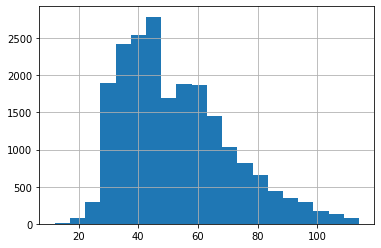

In [40]:
# общая площадь;
fast_look('total_area')

Распределение одномодальное, близко к нормальному, с вытянутым вправо хвостом, что логично:  
Количество больших квартир меньше, чем однушек - двушек. Гистограмма это подтверждает. Большинство квартир имеет площадь от 30 до 60 метров.
Как видели в отчете (профайле) у признака высокая корреляция с целевой переменной (ценой), а так же с жилой площадью, количеством комнат, и площадью кухни.

count    20901.000000
mean        30.247261
std         12.832443
min          2.000000
25%         18.000000
50%         29.000000
75%         39.000000
max         72.000000
Name: living_area, dtype: float64


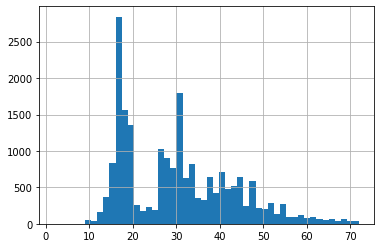

In [41]:
# жилая площадь;
fast_look('living_area', 50)

Я бы сказал, что Распределение двумодальное, хвост вытянут вправо. Видим пики примерно на 16 и 30 квадратов.
У признака высокая корреляция с целевой переменной, а также с общей площадью и количеством комнат.

count    20901.000000
mean         9.173161
std          2.761395
min          1.300000
25%          7.000000
50%          9.000000
75%         10.900000
max         17.000000
Name: kitchen_area, dtype: float64


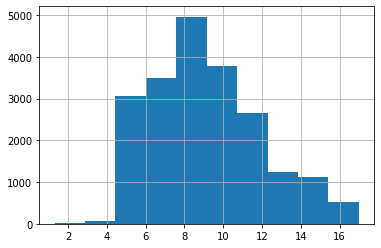

In [42]:
# площадь кухни;
fast_look('kitchen_area', 10)

Распределение близко к нормальному. Межквартильный размах - 3 метра (от 7 до 10). Выделяются какие то маломерки. Если бы у самого в детстве кухня не была 3.5 квадрата, предложил бы их удалить, как что то нереальное.
Есть корреляция с ценой и общей площадью.

count    2.090100e+04
mean     5.012709e+06
std      2.871288e+06
min      4.300000e+05
25%      3.300000e+06
50%      4.400000e+06
75%      6.000000e+06
max      4.800000e+07
Name: last_price, dtype: float64


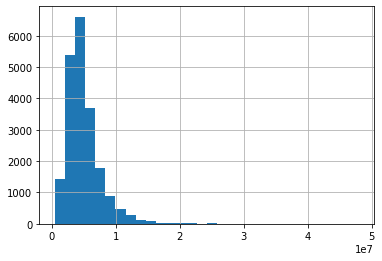

In [43]:
# цена объекта - она же целевая переменная.
fast_look('last_price', 30)

array([[<AxesSubplot:title={'center':'last_price'}>]], dtype=object)

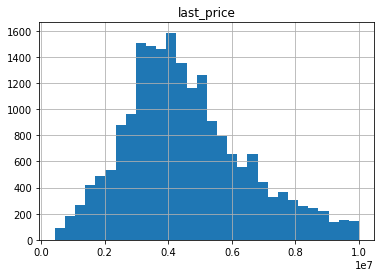

In [44]:
# посмотрим без хвоста
data[data['last_price']<data['last_price'].quantile(0.95)].hist('last_price', bins=30)

Нормальное распределение. Остался хвост из ооочень дорогих квартир. Наверное там унитазы золотые ))
90% квратир в пределах от 1.8 до 15 миллионов. Медианная стоимость 4.4 млн.
Хорошая корреляция с площадями (общей, жилой, кухни), кол-вом комнат и высотой потолков.


count    20901.00000
mean         1.92474
std          0.88967
min          0.00000
25%          1.00000
50%          2.00000
75%          3.00000
max          6.00000
Name: rooms, dtype: float64


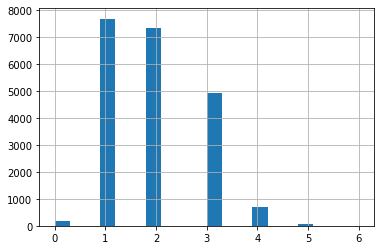

In [45]:
# количество комнат;
fast_look('rooms')

Из графика видно, что самыми популярными являются однушки. Чуть меньше двушки. Еще меньше трешки.
Большие квартиры, как и студии маловостребованы. В маленькой неудобно, а за большую - сильно много за комуналку платить ))


count    12711.000000
mean         2.689674
std          0.262975
min          1.000000
25%          2.500000
50%          2.600000
75%          2.750000
max         10.000000
Name: ceiling_height, dtype: float64


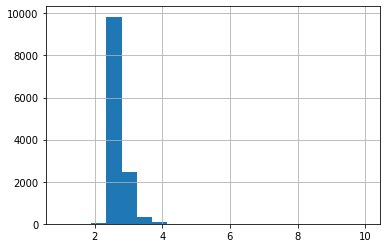

In [46]:
# высота потолков;
fast_look('ceiling_height')

In [47]:
data['height_cat'].value_counts()

средние потолки                9790
нет данных о высоте потолка    8190
высокие потолки                2848
низкие потолки                   73
Name: height_cat, dtype: int64

In [48]:
# посмотрим по категориям есть ли польза какая то от потолков
data[mask].groupby('height_cat')['price_per_1m'].median()

height_cat
высокие потолки                114207.5
нет данных о высоте потолка     96491.0
низкие потолки                 101111.0
средние потолки                 97777.0
Name: price_per_1m, dtype: float64

Чисто теоретически, имея полный адрес, можно подтягивать серию здания, год постройки и т.д.(если найти какие нибудь кадастровые данные) и можно было бы как то высоту потолков заполнять, и использовать этот признак в модели как числовой.
Из категориального признака по высоте потолков можно сделать вывод, что высокие потолки ценятся дороже. При построении модели можно поиграть с категориями.

count    20901.000000
mean         5.877039
std          4.859815
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         27.000000
Name: floor, dtype: float64


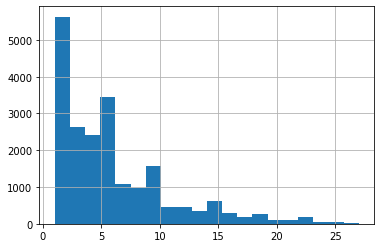

In [49]:
# этаж квартиры;
fast_look('floor')

Распределение Пуассона, что логично. В больших зданиях есть маленькие этажи, а в маленьких зданиях очень высоких этажей нет...

другой       0.734223
последний    0.137170
первый       0.128606
Name: floor_type, dtype: float64

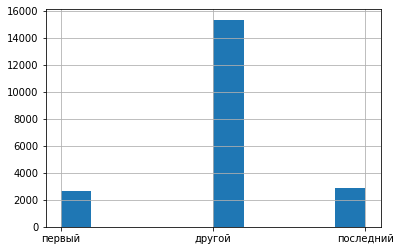

In [50]:
# тип этажа квартиры («первый», «последний», «другой»);
data['floor_type'].hist()
data['floor_type'].value_counts(normalize=True)

In [51]:
# Жизненный опыт показывает, что должна быть корреляция с ценой. Попробуем на какой нибудь более менее однородной выборке
mask = ((data['locality_name']=='Санкт-Петербург')&
        (data['total_area'].between(40,60))&
        data['cityCenters_nearest'].between(13000,16000))
data[mask].groupby('floor_type')['price_per_1m'].median()

floor_type
другой       100000
первый        86363
последний     92553
Name: price_per_1m, dtype: int64

По количеству: Первый и последний этажи примерно по 13% в выборке, остальные 73%. Гипотеза, предложенная на жизненном опыте подтвердилась. Видим, что цена у первых и последних этажей процентов на 10-15 ниже. Не любят их.

count    20901.000000
mean        10.748433
std          6.550931
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         29.000000
Name: floors_total, dtype: float64


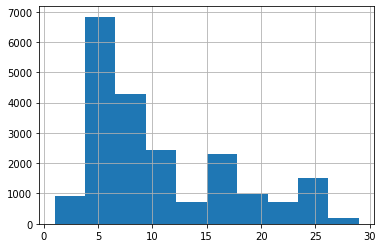

In [52]:
# общее количество этажей в доме;
fast_look('floors_total',10)

In [53]:
# Тоже жизненный опыт подсказывает, что в малоэтажках аналогичные квартиры будут дешевле. Посмотрим внимательнее
data['floors_total'].value_counts()

5     5268
9     3606
12    1236
16    1229
10    1048
25     962
4      959
17     763
6      607
3      559
14     515
18     446
24     435
7      417
2      344
15     321
23     315
19     306
8      267
22     261
20     220
13     191
11     164
27     161
21     142
26     116
1       21
28      21
29       1
Name: floors_total, dtype: int64

In [54]:
# разобьем на категории и посмотрим зависимость целевой переменной.
def make_type_building(floors):
    if floors <= 6:
        return 'малоэтажки'
    elif 6 < floors <= 12:
        return 'средние'
    else:
        return 'высотки'

data['build_type'] = data['floors_total'].apply(make_type_building)

# используемм уже сделанную выборку, считаем ее однородной
data[mask].groupby('build_type')['price_per_1m'].median()

build_type
высотки       112736.0
малоэтажки     85304.5
средние        95333.0
Name: price_per_1m, dtype: float64

Да, жизненный опыт опять не обманул. Гипотеза подтвердилась. Малоэтажки народ любит меньше, чем высотки. Тянет людей к небу, даже переплачивать за это готовы.

count    20901.000000
mean     14060.368690
std       6719.407866
min        208.000000
25%      11615.000000
50%      13065.000000
75%      15288.000000
max      61495.000000
Name: cityCenters_nearest, dtype: float64


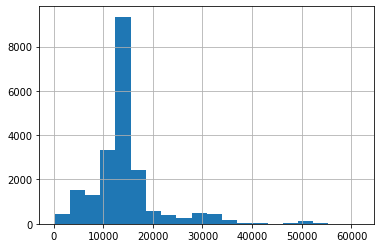

In [55]:
# расстояние до центра города в метрах;
fast_look('cityCenters_nearest')

In [56]:
# такая ж гипотеза на жизненном опыте: в Центре дороже, за КАДом дешевле.
def make_distance_type(km):
    if km <= 5000:
        return 'центровые'
    elif 5000 < km <= 10000:
        return 'городские'
    else:
        return 'закадыши'
    
data['distance_type'] = data['cityCenters_nearest'].apply(make_distance_type)

(data[(data['locality_name']=='Санкт-Петербург')&
      (data['total_area'].between(40,60))].groupby('distance_type')['price_per_1m'].median()
)

distance_type
городские    110824.5
закадыши      97619.0
центровые    125000.0
Name: price_per_1m, dtype: float64

Видим большой пик, тысячах так на 13 метров. Следствие заполнения пропусков медианой. Жизненная гипотеза подтверждена цифрами: в центре дороже, а "за КАДом жизни нет" поэтому дешевле. Различие существенное.  
PS. еще мы знаем что у признака корреляция с расстоянием до аэропорта

count    20901.000000
mean     27858.145065
std      10522.616372
min       6450.000000
25%      20602.000000
50%      26763.000000
75%      33914.000000
max      54784.000000
Name: airports_nearest, dtype: float64


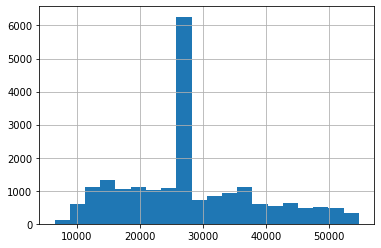

In [57]:
# расстояние до ближайшего аэропорта;
fast_look('airports_nearest')

In [58]:
# тоже сделаем выборку, чтобы посмотреть - есть ли зависимость к цене. Жизненный опыт тут пасует
def make_distance_air(km):
    if km <= 20000:
        return 'взлетные'
    elif 20000 < km <= 40000:
        return 'средние'
    else:
        return 'отшельники'
    
data['air_dis_cat'] = data['airports_nearest'].apply(make_distance_air)
data[(data['locality_name']=='Санкт-Петербург')&(data['total_area'].between(40,60))].groupby('air_dis_cat')['price_per_1m'].median()

air_dis_cat
взлетные       97777.0
отшельники     96662.5
средние       104000.0
Name: price_per_1m, dtype: float64

Видим странный пик (от филна медианой). Здесь тоже жизненный опыт не обманул: вряд ли тут есть зависимость, либо надо другие категории смотреть. Типа, если впритык к аэропорту, то спать мешает, а так особой зависимости нет. Разница в цене мне кажется обоснована больше тем, что к средним центровые попадают. Геометрия - царица наук...

count    20901.000000
mean       472.437635
std        191.553082
min          1.000000
25%        460.000000
50%        460.000000
75%        460.000000
max       3190.000000
Name: parks_nearest, dtype: float64


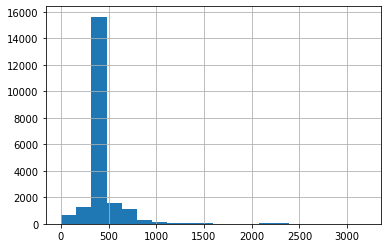

In [59]:
# расстояние до ближайшего парка;
fast_look('parks_nearest')

Гистограмма напоминает неприличный жест. Опять последствия заполнения медианой. И этот жест как бы намекает, что мы не хотим использовать такой признак. Я бы его удалил. Много пропусков. Либо сделал бы какой нибудь категориальный признак из него (до медианы, медиана, и больше медианы).
Либо как вариант еще с учетом Nan которые мы тут заполняли, тогда можно было бы разбить на "Нет парка", "есть парк".

count                   20901
unique                   1470
top       2018-02-01 00:00:00
freq                      328
first     2014-11-27 00:00:00
last      2019-05-03 00:00:00
Name: first_day_exposition, dtype: object


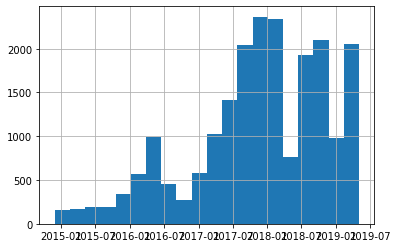

In [60]:
# день и месяц публикации объявления.
fast_look('first_day_exposition')

In [61]:
# а вот здесь руки чешутся посмотреть временной ряд стоимости квадратного метра (в какой нибудь однородной выборке)
time_df = data[mask].groupby(['year_public', 'month_public'], as_index=True).agg({'price_per_1m':'median'})

time_df['rolling'] = time_df['price_per_1m'].rolling(3).mean()
time_df

price_per_1m        rolling
year_public month_public                             
2014        11                104545.0            NaN
            12                106400.0            NaN
2015        1                  97826.0  102923.666667
            2                  91176.0   98467.333333
            3                  86956.0   91986.000000
...                                ...            ...
2019        1                 104878.0  104455.333333
            2                 111391.0  108756.333333
            3                 109090.0  108453.000000
            4                 104444.0  108308.333333
            5                 109058.5  107530.833333

[54 rows x 2 columns]

<AxesSubplot:xlabel='year_public,month_public'>

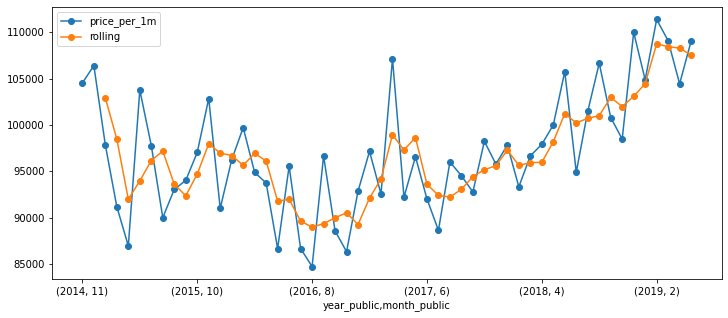

In [62]:
time_df.plot(kind='line', marker='o', figsize = (12,5))

count    20901.000000
mean         2.573992
std          1.793353
min          0.000000
25%          1.000000
50%          3.000000
75%          4.000000
max          6.000000
Name: day_public, dtype: float64


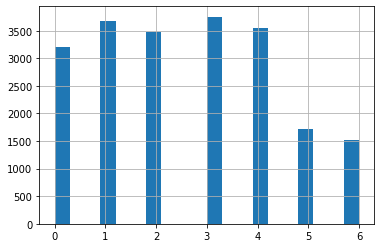

In [63]:
# посмотрим гистограммы по дням, месяцам, годам
fast_look('day_public')

Видно, что на выходных подавалось меньше объявлений, чем в будние дни

count    20901.000000
mean         6.394192
std          3.487210
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month_public, dtype: float64


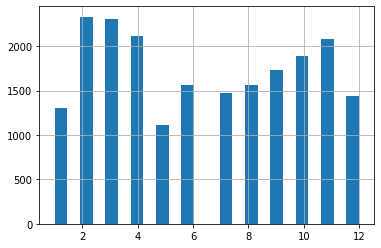

In [64]:
fast_look('month_public',24)

Так же выделяется некая сезонность. Спад предложений в летние месяцы (точнее с мая по август) и в зимние (декабрь-январь)

count    20901.000000
mean      2017.390938
std          1.019537
min       2014.000000
25%       2017.000000
50%       2017.000000
75%       2018.000000
max       2019.000000
Name: year_public, dtype: float64


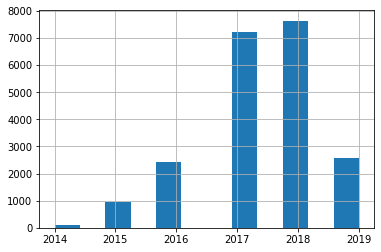

In [65]:
fast_look('year_public',12)

Тренд увеличения объявлений по годам (2019 год всего 4 месяца, поэтому он ниже), возможно обусловлено ростом популярности платформы, на которой выкладывались объявления.

count    20901.000000
mean       162.273097
std        197.416239
min          1.000000
25%         45.000000
50%         95.000000
75%        191.000000
max       1580.000000
Name: days_exposition, dtype: float64


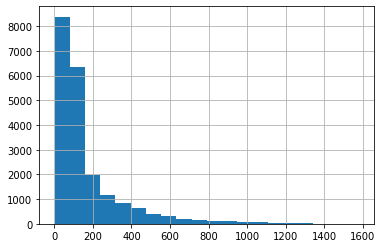

In [66]:
# Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней «висело» каждое объявление
fast_look('days_exposition')

<AxesSubplot:>

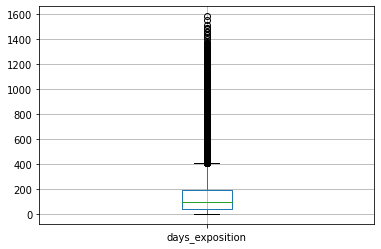

In [67]:
data.boxplot('days_exposition')

Распределение Пуассона. 90% квартир продавались в интервале от 9 до 647 дней. 
межквартильный размах от 45 до 191 дня. Можно сказать меньше 45  дней - быстро, больше 191 - долго. 
Медиана - 3 месяца, среднее - почти полгода, что говорит о выбросах в большую сторону.
Жизненный опыт подсказывает, что чем дороже цена средней цены по рынку, тем дольше она продается.
Но чтобы проверить данную гипотезу нам по идее нужно сначала сделать ml-модель по предсказанию цены и посмотреть зависимость разницы между ценой в датасете и предсказанной ценой. Для ml-модели нам этот параметр не нужен. Наоборот, сделав предсказание на первом шаге можно будет делать прогноз как быстро продасться квартира при назначении той или инлй цены.

<div class="alert alert-info"> <b>Комментарии студента:</b>
Понятие быстро\медленно, оно субъективно. Я ориентировался на 1 и 3 квантили. Меньше 1го - быстро, дольше 3-его медленно.  
Можно за пределы взять по 5% первых и последних.  
Если "необычно" быстро или долго, то за пределы можно взять q1-1.5IQR и q1+1.5IQR. Тогда "необычно" быстрых нет,  
а "необычно" долго это более 410 дней.</div>

<AxesSubplot:>

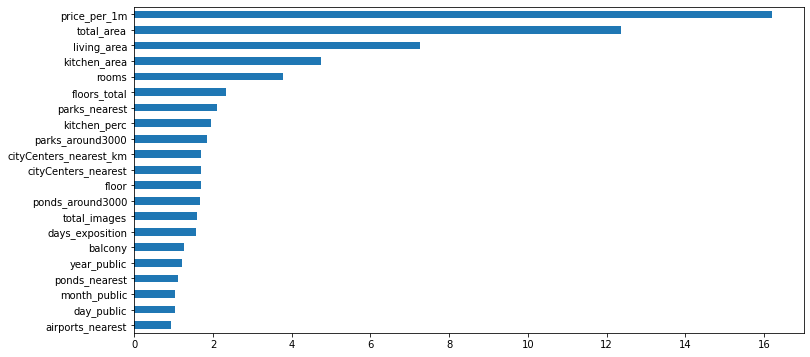

In [68]:
# посмотрим значимость каждого цифрового признака
#Используем функцию f_classif для анализа значимости признака для нашей линейной модели
num_features = data.select_dtypes(include=['float', 'int']).columns.to_list()
num_features.remove('ceiling_height')
num_features.remove('last_price')
imp_num = pd.Series(f_classif(data[num_features], data['last_price'])[0], index = num_features)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh', figsize=(12,6))

На графике видны наиболее важные по корреляции признаки для целевой переменной.
Некоторые можно не учитывать: например, цену квадратного метра мы считали через цену, понятно, что у нее наибольшая корреляция.

In [69]:
# так же можно посмотреть матрицу корреляций и heatmap
data.corr().round(2)

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,studio,open_plan,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,kitchen_perc,price_per_1m,day_public,month_public,year_public,cityCenters_nearest_km
total_images,1.00,0.16,0.12,0.09,0.01,0.02,0.10,0.03,-0.03,-0.03,0.06,0.05,0.01,-0.02,0.03,-0.00,-0.03,-0.00,-0.05,-0.06,0.12,-0.01,0.00,0.14,-0.02
last_price,0.16,1.00,0.67,0.40,0.41,0.15,0.56,0.11,-0.06,-0.04,0.48,0.06,0.01,-0.27,0.28,0.05,0.09,-0.04,0.05,-0.22,0.72,-0.01,-0.00,-0.00,-0.26
total_area,0.12,0.67,1.00,0.80,0.29,-0.02,0.92,-0.03,-0.12,-0.07,0.48,0.07,-0.01,-0.13,0.12,0.02,0.08,-0.03,0.09,-0.55,0.04,-0.01,0.01,-0.06,-0.13
rooms,0.09,0.40,0.80,1.00,0.09,-0.23,0.89,-0.17,-0.17,-0.11,0.08,0.01,-0.03,-0.07,0.08,-0.02,0.02,-0.01,0.06,-0.73,-0.15,0.00,-0.00,-0.03,-0.07
ceiling_height,0.01,0.41,0.29,0.09,1.00,-0.03,0.23,-0.02,0.03,0.01,0.31,-0.05,-0.07,-0.28,0.22,-0.03,0.17,-0.08,0.05,0.02,0.32,-0.01,0.01,-0.07,-0.28
floors_total,0.02,0.15,-0.02,-0.23,-0.03,1.00,-0.17,0.67,0.07,0.05,0.37,0.17,0.12,0.02,-0.13,0.08,-0.12,0.05,-0.03,0.39,0.28,0.01,0.01,-0.00,0.02
living_area,0.10,0.56,0.92,0.89,0.23,-0.17,1.00,-0.13,-0.07,-0.04,0.23,0.03,-0.03,-0.12,0.13,-0.01,0.06,-0.02,0.07,-0.70,-0.04,-0.00,-0.00,-0.04,-0.12
floor,0.03,0.11,-0.03,-0.17,-0.02,0.67,-0.13,1.00,0.04,0.04,0.25,0.17,0.09,0.02,-0.09,0.06,-0.08,0.04,-0.03,0.27,0.20,0.01,0.02,0.00,0.02
studio,-0.03,-0.06,-0.12,-0.17,0.03,0.07,-0.07,0.04,1.00,-0.00,-0.09,0.03,-0.02,-0.01,-0.03,0.00,0.01,0.00,-0.02,0.06,0.04,-0.00,0.00,0.01,-0.01
open_plan,-0.03,-0.04,-0.07,-0.11,0.01,0.05,-0.04,0.04,-0.00,1.00,-0.06,0.04,-0.01,-0.01,-0.02,0.00,0.01,-0.00,-0.02,0.03,0.01,0.01,0.03,-0.02,-0.01


<AxesSubplot:>

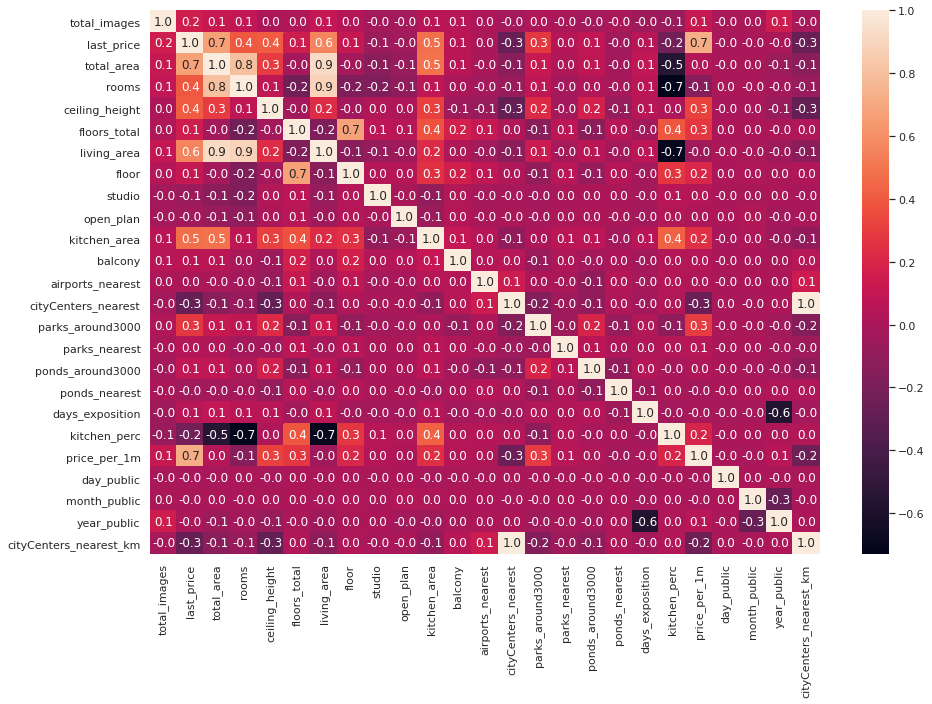

In [70]:
# И heatmap для наглядности.
sns.set(rc={'figure.figsize':(15,10)})
sns.heatmap(data.corr(), annot=True, fmt=".1f")

Исходя из этого, из числовых признаков наибольшей корреляцией обладают: площади (все), комнаты, расстояния до центра и парка.  
Причем жилая может быть избыточной, так как у нее кореляция с общей площадью и комнатами 0.9.  
Так же ранее мы посмотрели, что на цену квадратного метра (а значит и на общую стоимость) влияют такие признаки, как категория этажей (первый и последний не предлагать), так и этажность здания (пятиэтажки без лифта - не комильфо, вся надежда на "реновацию").


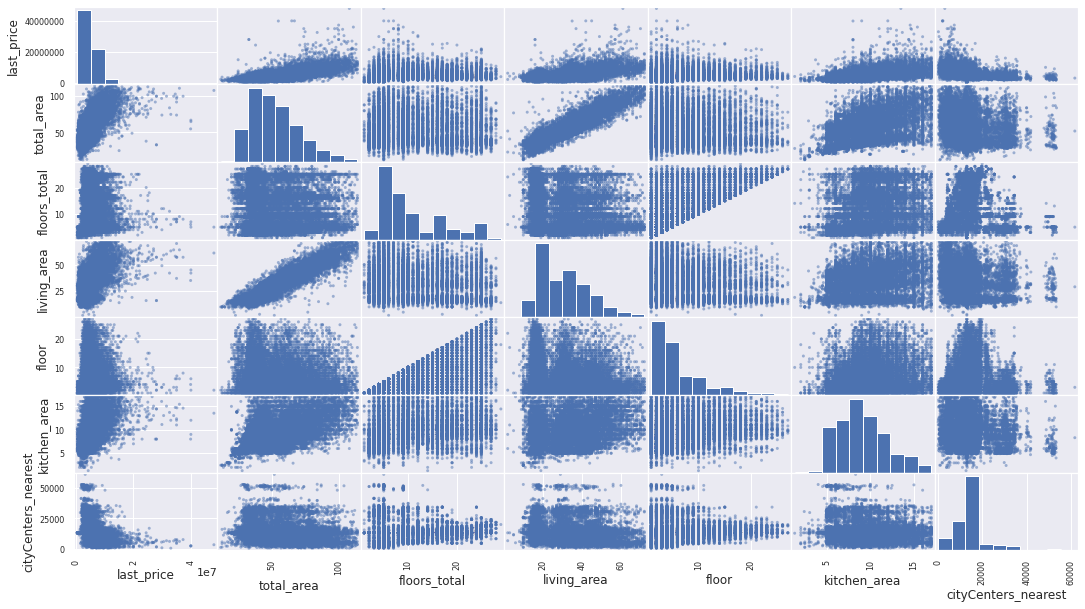

In [71]:
# посмотрим наглядно, признаки с корреляциями
corr_features = ['last_price', 'total_area', 'floors_total', 'living_area',
                 'floor',  'kitchen_area', 'cityCenters_nearest']
pd.plotting.scatter_matrix(data[corr_features],figsize=(18,10));

Наглядно линейная зависимость наблюдается у целевой переменной и общей площадью, а так же общей и жилой площадаями. Интересный график и этажей (квартиры здания) - напоминает выстроившиеся в ряд по росту здания )

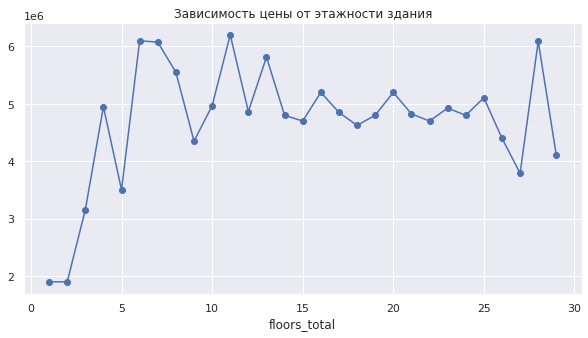

In [72]:
# цена - этаж здания
(
data.groupby('floors_total')['last_price']
    .median()
    .plot(kind='line', marker='o', figsize=(10,5), title='Зависимость цены от этажности здания')
);

Видно, что цена квартир высоких зданий, выше чем у низких

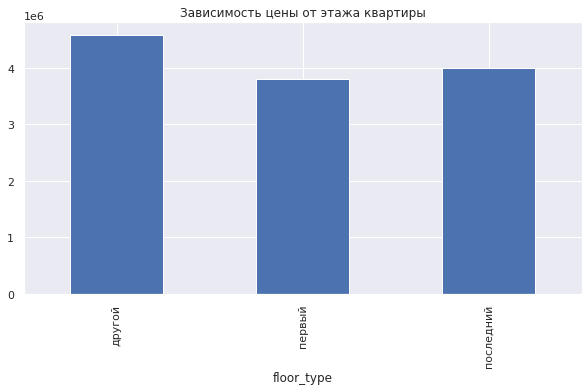

In [73]:
# цена - "первый последний не предлагать"
(
    data.groupby('floor_type')['last_price']
    .median()
    .plot(kind='bar', figsize=(10,5), title='Зависимость цены от этажa квартиры')
);

Видим, что дешевле всего первые этажи, последние чуть дороже. Но все равно они ценятся ниже чем другие этажи

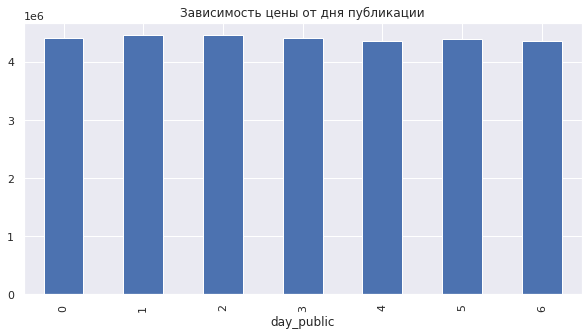

In [74]:
# цена - в зависимости от дня публикации
(
    data.groupby('day_public')['last_price']
    .median()
    .plot(kind='bar', figsize=(10,5), title='Зависимость цены от дня публикации')
);

Какой либо зависимости цены от дня публикации не наблюдается

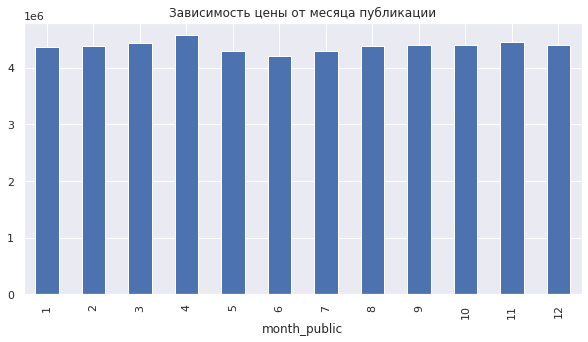

In [75]:
# цена - в зависимости от месяца публикации
(
    data.groupby('month_public')['last_price']
    .median()
    .plot(kind='bar', figsize=(10,5), title='Зависимость цены от месяца публикации')
);

есть небольшая просадка в июне, но я бы поостерегся сказать, что это закономерность.

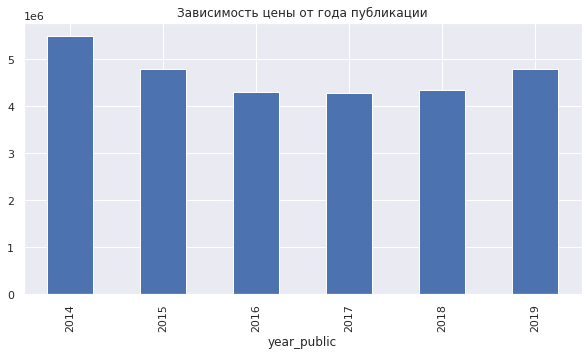

In [76]:
# цена - в зависимости от года публикации
(
    data.groupby('year_public')['last_price']
    .median()
    .plot(kind='bar', figsize=(10,5), title='Зависимость цены от года публикации')
);

В разрезе лет можно сказать, что цена сначала чуть снижалась до 16 года, а потом росла. На мой взгляд это как раз лучше видно на построенном чуть выше графике, где мы строили временной ряд

In [77]:
# Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений
(
data[data['locality_name'].isin(data['locality_name'].value_counts().head(10).index)]
    .groupby('locality_name')['price_per_1m'].mean().round(2).sort_values(ascending=False)
)

locality_name
Санкт-Петербург    109179.90
Пушкин             101219.59
Кудрово             96216.71
Парголово           94944.60
Мурино              87012.40
Шушары              79002.09
Колпино             75634.37
Гатчина             69107.35
Всеволожск          68937.03
Выборг              58111.28
Name: price_per_1m, dtype: float64

In [78]:
# еще вариант группировки
data.groupby('locality_name').agg({'balcony':'count', 'last_price':'median'}) \
    .sort_values(by = 'balcony', ascending = False) \
    .head(10)

,balcony,last_price
locality_name,,
Санкт-Петербург,13555,5150000.0
Мурино,564,3400000.0
Кудрово,435,3795000.0
Шушары,430,3940000.0
Всеволожск,380,3400000.0
Колпино,329,3600000.0
Пушкин,326,4925000.0
Гатчина,301,3080000.0
Парголово,267,4199000.0


Чем дальше от Питера, тем дешевле. Питер - самый дорогой, Выборг - самый дешевый (в этой выборке)

In [79]:
# Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца `locality_name` 
# и вычислите среднюю цену каждого километра. 
# Опишите, как стоимость объектов зависит от расстояния до центра города.

# я это уже делал, при оценке признака расстояния до центра. Повторение мать учения.
data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters_nearest_km')['price_per_1m'].mean().round(2)

cityCenters_nearest_km
0     152479.45
1     153489.46
2     140059.31
3     117344.58
4     126118.59
5     132017.92
6     130224.28
7     129320.76
8     121383.57
9     110238.41
10    110754.70
11    106548.87
12    107801.80
13    107572.29
14    104295.58
15    103343.89
16     99983.34
17     97022.52
18     96766.80
19     98387.79
20     87904.00
21     93713.87
22     91452.21
23     91385.55
24     86432.42
25     93149.32
26     88502.19
27     70312.00
28     81161.57
29     73390.00
Name: price_per_1m, dtype: float64

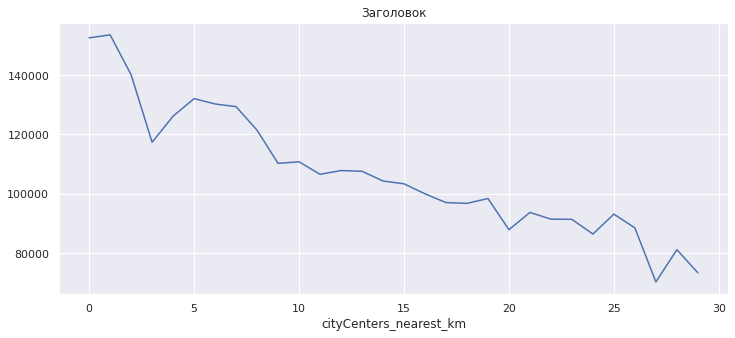

In [80]:
# для красоты
data[data['locality_name']=='Санкт-Петербург'].groupby('cityCenters_nearest_km')['price_per_1m'].mean().round(2)\
    .plot(kind='line', figsize=(12,5), title = 'Заголовок');

Видно, что чем дальше от центра, тем дешевле. Есть скачки, возможно из-за неоднородности объектов. Но тренд однозначный.

### Общий вывод

1. Сделал проект по предложенному шаблону, но он мне не понравился. Мы несколько раз по кругу ходили. Сначала пропуски по всем признакам, потом типы, потом выбросы, потом мы исследовали признак, у которого уже медиана торчит, так как мы ей пропуски заполнили.  
Считаю более целесообразным идти по каждому признаку и делать по нему все сразу. Сразу и оцениваем и описываем и смотрим с чем и как коррелирует и пропуски исходя из всего этого заполняем и от выбросов избавляемся.
2. Данные сырые. Очень много пропусков. Понятно, что для учебы. В реальной жизни нужно было бы работать над качеством заполнения в первую очередь и уже потом обработку делать.
3. Данные только для учебы, в настоящее время они увы, устарели. Тренд к росту (как подсказывает мой жизненный опыт) немного изменил угол наклона и к сожалению далеко не в меньшую сторону.
4. По сути имеем временной ряд. При построении модели необходим учитывать, что цена на аналогичные квартиры в 2016 и в 2019 гг сильно отличается.
Скорее всего надо делать временные срезы, добавляьт коэффициенты роста и модель обучать не на этой цене, а на цене, приведенной к какому нибудь одному моменту.

Итого: пропуски, выбросы, дубликаты и так далее почистили. Осталось сделать get_dummies на категориальные признаки, учесть сказанное в 4-м пункте и можно строить модельку ml.

**Проделанная работа:**
- Выявлены и обработаны пропуски. В некоторых признаках пропуски заполнены на основе предсказания простой модели RandomForestRegressor. В некоторых более оптимальным решением было заполнение медианными значениями. Некоторые пропуски оставили без изменений, чтобы в дальнейшем использовать для построения категориальных признаков;
- Обработаны выбросы и аномальные значения;
- Приведены к единообразию названия населенных пунктов;
- Оптимизирована схема хранения данных для экономии ресурсов;
- Сгенерированы дополнительные признаки для наглядности анализа представленных данных.
- Проведен исследовательский анализ данных. Выявлены зависимости и корреляции между признаками

**Выводы**  
Выделены признаки, которые оптимально использовать для построения модели прогнозирования цены недвижимости:
- Все виды площадей (общая, жилая, кухни)
- количество комнат
- высота потолков (как категориальный признак)
- этажность здания
- этаж квартиры
- locality_name
- расстояние до центра

**Рекомендации**
- Настроить получение данных (уменьшить  или исключить, пропуски, выбросы и неявные дубликаты).
- Оптимизировать хранение данных для оптимизации используемой памяти
- Для построения модели получить и использовать  более свежие данные
- Учесть изменение цены на квартиры во времени
- Построить модель ml для прогноза цены.
Конечный продукт можно будет использовать:
- В брокерских целях (для риелторских компаний, которые занимаются куплей/продажей квартир) для поиска квартир ниже рынка,
- Для правильного бюджетирования строительных компаний (можно сделать прогноз цены будущих квартир)
- Для улучшения сервиса доски объявлений (Можно сразу подсказывать цену человеку, который размещает объявление)